In [1]:
import scib
import scanpy as sc
import numpy as np
import pandas as pd
import anndata
import os
import umap
from sklearn.manifold import TSNE

/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


In [11]:
dirs = { "1_0.1": [], "3_0.1": [], "5_0.1": [], "1_0.5": [], "3_0.5": [], "5_0.5": [] }

for tree in [1, 3, 5]:
    for ncell in [500, 800]:
        for ngene in [110, 200, 500]:
            for sigma in [0.1, 0.5]:
                for seed in [1, 2, 3, 4]:
                    root_dir = f"/home/lhc/scMultiSim/bench/unif/0/tree{tree}_{ncell}_cells{ngene}_genes_sigma{sigma}_{seed}/integ3/"
                    dirs[f"{tree}_{sigma}"].append(root_dir)

In [12]:
def get_metrics(tool):
    for tree, root_dirs in dirs.items():
        ari_list = []
        nmi_list = []
        gc_list = []
        asw_label_list = []
        asw_batch_list = []

        for root_dir in root_dirs:
            print(root_dir)
            meta_orig = pd.read_csv(os.path.join(root_dir, "meta.csv"), index_col=0)
            counts_orig = pd.read_csv(os.path.join(root_dir, "counts_s.csv"), index_col=0)
            adata = anndata.AnnData(X=np.row_stack([
                counts_orig[meta_orig.batch == 2].values,
                counts_orig[meta_orig.batch == 3].values
            ]), dtype=counts_orig.values.dtype)

            if tool == "seurat":
                data_path = root_dir + "out_seurat/"
                counts = pd.read_csv(data_path + "q_umap.csv", sep=",")
                ref_counts = pd.read_csv(data_path + "ref_umap.csv", sep=",")
            else:
                data_path = root_dir + "out_uinmf/"
                counts = pd.read_csv(data_path + "q_embed.csv", sep=",").T
                ref_counts = pd.read_csv(data_path + "ref_embed.csv", sep=",").T

            meta = pd.read_csv(data_path + "q_meta.csv", sep=",")
            ref_meta =  pd.read_csv(data_path + "ref_meta.csv", sep=",")
            
            ##
            adata.obs["pop"] = np.concatenate([
                meta["pop"].astype(str).astype('category').to_numpy(),
                ref_meta["pop"].astype(str).astype('category').to_numpy()
            ])
            adata.obs["celltype"] = adata.obs["pop"]
            adata.obs["batch"] = np.concatenate([
                meta["batch"].astype(str).astype('category').to_numpy(),
                ref_meta["batch"].astype(str).astype('category').to_numpy()
            ])
            adata.obs["batch"] = adata.obs["batch"].astype("category")
            adata.obs["celltype"] = adata.obs["celltype"].astype("category")
            adata.layers["counts"] = adata.X

            adata_int = adata.copy()
            adata_int.obsm["X_emb"] = np.row_stack([counts.values, ref_counts.values])

            if tool == "seurat":
                n_pcs = 30
            else:
                n_pcs = 30
            scib.pp.reduce_data(
                adata, pca=True, n_top_genes=None, neighbors=True, umap=False, pca_comps = n_pcs
            )
            scib.pp.reduce_data(
                adata_int, batch_key="batch", pca=True, n_top_genes=None, neighbors=True, umap=False, pca_comps = n_pcs, use_rep="X_emb"
            )
            me = scib.me.metrics(adata, adata_int, embed="X_emb", batch_key="batch", label_key="celltype", ari_=True, nmi_=True, graph_conn_=True,silhouette_=True)
            ##
            
            ari_list.append(me.loc["ARI_cluster/label", 0])
            nmi_list.append(me.loc["NMI_cluster/label", 0])
            gc_list.append(me.loc["graph_conn", 0])
            asw_label_list.append(me.loc["ASW_label", 0])
            asw_batch_list.append(me.loc["ASW_label/batch", 0])

        pd.DataFrame.from_dict({
            "ari": ari_list,
            "nmi": nmi_list,
            "gc": gc_list,
            "asw_label": asw_label_list,
            "asw_batch": asw_batch_list
        }).to_csv(os.path.join("/home/lhc/scMultiSim/bench/unif/0/", f"{tool}3_tree{tree}.csv"))

In [13]:
get_metrics("seurat")
get_metrics("uinmf")

/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells110_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells110_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells110_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells110_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells200_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells200_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells200_genes_sigma0.1_3/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells200_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells500_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells500_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells500_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells500_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells110_genes_sigma0.1_1/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells110_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells110_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells110_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells200_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells200_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells200_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells200_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells500_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells500_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells500_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells500_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells110_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells110_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells110_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells110_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells200_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells200_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells200_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells200_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells500_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells500_genes_sigma0.1_2/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells500_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells500_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells110_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells110_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells110_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells110_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells200_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells200_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells200_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells200_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells500_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells500_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells500_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells500_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_3/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_4/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_4/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_2/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells110_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells110_genes_sigma0.5_2/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells110_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells110_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells200_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells200_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells200_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells200_genes_sigma0.5_4/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells500_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells500_genes_sigma0.5_2/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells500_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells500_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells110_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells110_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells110_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells110_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells200_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells200_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells200_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells200_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells500_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells500_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells500_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells500_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells110_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells110_genes_sigma0.5_2/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells110_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells110_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells200_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells200_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells200_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells200_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells500_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells500_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells500_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells500_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells110_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells110_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells110_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells110_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells200_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells200_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells200_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells200_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells500_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells500_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells500_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells500_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells110_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells110_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells110_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells110_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells200_genes_sigma0.1_1/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells200_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells200_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells200_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells500_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells500_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells500_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells500_genes_sigma0.1_4/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells110_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells110_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells110_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells110_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells200_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells200_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells200_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells200_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells500_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells500_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells500_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells500_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells110_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells110_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells110_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells110_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells200_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells200_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells200_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells200_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells500_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells500_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells500_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells500_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells110_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells110_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells110_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells110_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells200_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells200_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells200_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells200_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells500_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells500_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells500_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells500_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.1_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells110_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells110_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells110_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells110_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells200_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells200_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells200_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells200_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells500_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells500_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells500_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_500_cells500_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells110_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells110_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells110_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells110_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells200_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells200_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells200_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells200_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells500_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells500_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells500_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree1_800_cells500_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells110_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells110_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells110_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells110_genes_sigma0.5_4/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells200_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells200_genes_sigma0.5_2/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells200_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells200_genes_sigma0.5_4/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells500_genes_sigma0.5_1/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells500_genes_sigma0.5_2/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells500_genes_sigma0.5_3/integ3/
PCA


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_500_cells500_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells110_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells110_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells110_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells110_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells200_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells200_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells200_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells200_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells500_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells500_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells500_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree3_800_cells500_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells110_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_2/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_3/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells500_genes_sigma0.5_4/integ3/


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(
/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells110_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells200_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_1/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_2/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...
/home/lhc/scMultiSim/bench/unif/0/tree5_800_cells500_genes_sigma0.5_4/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Graph connectivity...


In [18]:
for tree, root_dirs in dirs.items():
    for root_dir in root_dirs:
        os.rename(os.path.join(root_dir, "../cci/out_seurat"), os.path.join(root_dir, "../integ/out_seurat"))

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_integ():
    df = None
    for tree in dirs.keys():
        for tool in ["seurat", "uinmf", "cobolt"]:
            se_dis = pd.read_csv(os.path.join("/home/lhc/scMultiSim/bench/unif/0/", f"{tool}3_tree{tree}.csv"))
            se_dis['tool'] = tool
            se_dis['tree'] = str(tree)
            if df is None:
                df = se_dis
            else:
                df = pd.concat([df, se_dis])

    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(40, 4))
    sns.set(style="darkgrid")
    sns.violinplot(x="tree", y="ari", hue="tool", data=df, palette="Pastel1", ax=axs[0]).set(ylim=(-0.1,1.1))
    sns.violinplot(x="tree", y="nmi", hue="tool", data=df, palette="Pastel1", ax=axs[1]).set(ylim=(-0.1,1.1))
    sns.violinplot(x="tree", y="gc", hue="tool", data=df, palette="Pastel1", ax=axs[2]).set(ylim=(-0.1,1.1))
    sns.violinplot(x="tree", y="asw_batch", hue="tool", data=df, palette="Pastel1", ax=axs[3]).set(ylim=(-0.1,1.1))
    axs[0].set_title("ari")
    axs[1].set_title("nmi")
    axs[2].set_title("graph_connectivity")
    axs[3].set_title("silhouette_batch")

    fig.savefig("unif_integ.pdf")
    plt.show()

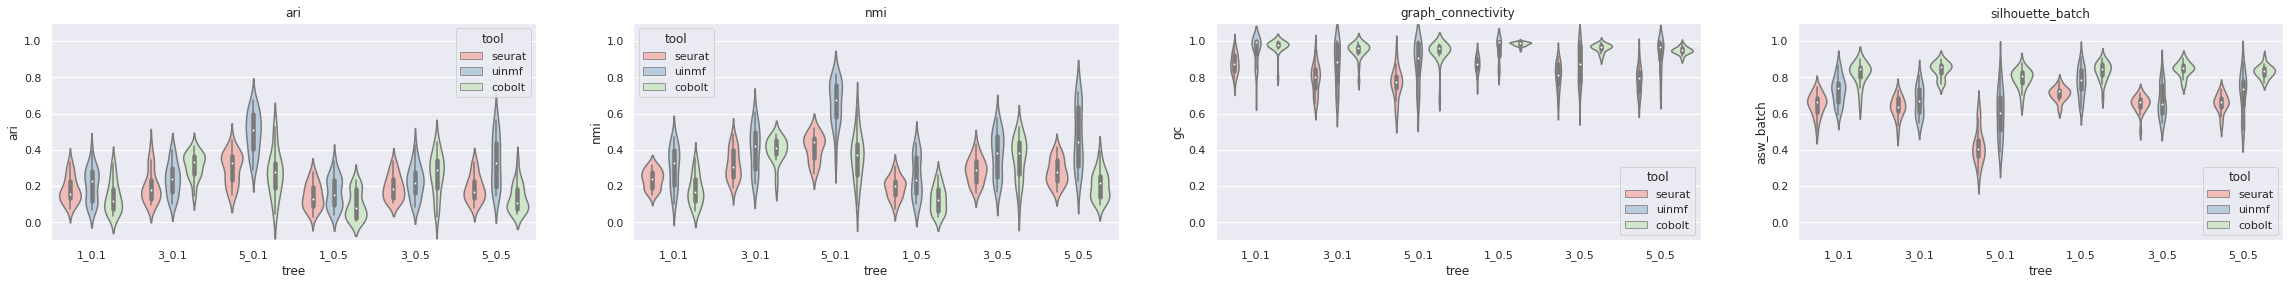

In [14]:
plot_integ()

In [16]:
def visualize(root_dir, tool):
    print(root_dir)
    
    if tool == "cobolt":
        adata = anndata.read(os.path.join(root_dir, "res.h5ad"))
    else:
        meta_orig = pd.read_csv(os.path.join(root_dir, "meta.csv"), index_col=0)
        counts_orig = pd.read_csv(os.path.join(root_dir, "counts_s.csv"), index_col=0)
        adata = anndata.AnnData(X=np.row_stack([
            counts_orig[meta_orig.batch == 2].values,
            counts_orig[meta_orig.batch == 3].values
        ]), dtype=counts_orig.values.dtype)

        if tool == "seurat":
            data_path = root_dir + "out_seurat/"
            counts = pd.read_csv(data_path + "q_umap.csv", sep=",")
            ref_counts = pd.read_csv(data_path + "ref_umap.csv", sep=",")
        else:
            data_path = root_dir + "out_uinmf/"
            counts = pd.read_csv(data_path + "q_embed.csv", sep=",").T
            ref_counts = pd.read_csv(data_path + "ref_embed.csv", sep=",").T

        meta = pd.read_csv(data_path + "q_meta.csv", sep=",")
        ref_meta =  pd.read_csv(data_path + "ref_meta.csv", sep=",")

        adata.obs["pop"] = np.concatenate([
            meta["pop"].astype(str).astype('category').to_numpy(),
            ref_meta["pop"].astype(str).astype('category').to_numpy()
        ])
        adata.obs["celltype"] = adata.obs["pop"]
        adata.obs["batch"] = np.concatenate([
            meta["batch"].astype(str).astype('category').to_numpy(),
            ref_meta["batch"].astype(str).astype('category').to_numpy()
        ])
        adata.obs["batch"] = adata.obs["batch"].astype("category")
        adata.obs["celltype"] = adata.obs["celltype"].astype("category")
        adata.layers["counts"] = adata.X

        adata_int = adata.copy()
        adata_int.obsm["X_emb"] = np.row_stack([counts.values, ref_counts.values])

        if tool == "seurat":
            n_pcs = 1
        else:
            n_pcs = 5
        scib.pp.reduce_data(
            adata, pca=True, n_top_genes=None, neighbors=True, umap=False, pca_comps = n_pcs
        )
        scib.pp.reduce_data(
            adata_int, batch_key="batch", pca=True, n_top_genes=None, neighbors=True, umap=False, pca_comps = n_pcs, use_rep="X_emb"
        )
        me = scib.me.metrics(adata, adata_int, embed="X_emb", batch_key="batch", label_key="celltype", ari_=True, nmi_=True, graph_conn_=True,silhouette_=True)
        print(me)
        
    if tool == "seurat":
        ump = adata_int.obsm["X_emb"]
    else:
        ump = TSNE(n_components=2).fit_transform(adata_int.obsm["X_emb"])
        
    df = pd.DataFrame.from_dict({
        "x": ump[:, 0],
        "y": ump[:, 1],
        "celltype": adata.obs["celltype"],
        "batch": adata.obs["batch"]
    }).sample(frac=1)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.set(style="darkgrid")
    sns.scatterplot(x="x", y="y", hue="celltype", data=df, size=1, ax=axs[0])
    sns.scatterplot(x="x", y="y", hue="batch", data=df, size=1, ax=axs[1])
    axs[0].set_title("Cell Type")
    axs[1].set_title("Batch")

    plt.show()

/home/lhc/scMultiSim/bench/unif/0/tree5_500_cells200_genes_sigma0.1_3/integ3/
PCA
Nearest Neigbours
PCA
Nearest Neigbours
NMI...
ARI...
Silhouette score...
Graph connectivity...
                                  0
NMI_cluster/label          0.447169
ARI_cluster/label          0.363497
ASW_label                  0.539046
ASW_label/batch            0.424660
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.808127
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN


/home/lhc/.pyenv/versions/miniforge3-4.10.3-10/envs/scMultiSim/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


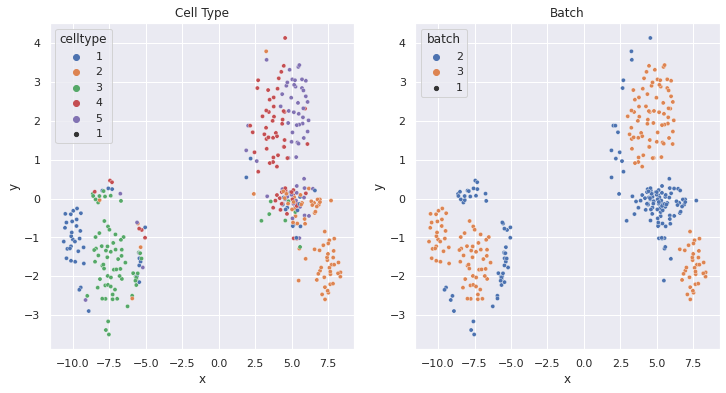

In [28]:
visualize(dirs["5_0.1"][6], "seurat")